 # Import Necessary Libraries

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
from tqdm import tqdm
from collections import Counter


# Set the Dataset Path

In [34]:
# Define dataset path and target image size
dataset_folder = '/Users/rahatrihan/Downloads/Animals'
target_image_size = (128, 128)


# Check if the dataset path exists
if not os.path.exists(dataset_path):
    print(f"Error: Dataset path '{dataset_path}' does not exist.")


# Load Images from Dataset

In [37]:
# Load grayscale images and their labels
def load_images_from_folder(folder_path, target_size=(128, 128)):
    images, labels = [], []

    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for filename in tqdm(os.listdir(category_path), desc=f"Loading {category}"):
                img_path = os.path.join(category_path, filename)
                try:
                    # Load the image in grayscale
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Resize the image to the target size
                        img = cv2.resize(img, target_size)
                        images.append(img)
                        labels.append(category)
                except Exception as e:
                    print(f"Error processing image: {img_path}")
                    print(f"Error details: {e}")
                    continue

    return np.array(images), np.array(labels)

# Load images and labels from the dataset
images, labels = load_images_from_folder(dataset_folder, target_size=target_image_size)
print(f"Loaded {len(images)} images and {len(labels)} labels.")


Loading Lion: 100%|████████████████████████████| 32/32 [00:00<00:00, 971.64it/s]

Loaded 170 images and 170 labels.


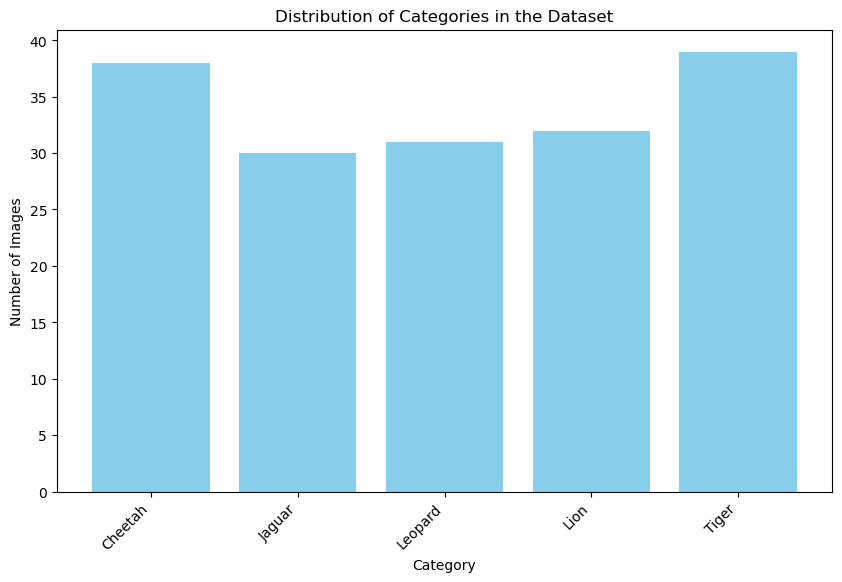

In [39]:
# Visualize the distribution of images across categories
unique, counts = np.unique(labels, return_counts=True)  # Get category counts
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue')  # Plot a bar chart
plt.title("Distribution of Categories in the Dataset")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.show()


# Display Sample Grayscale Images

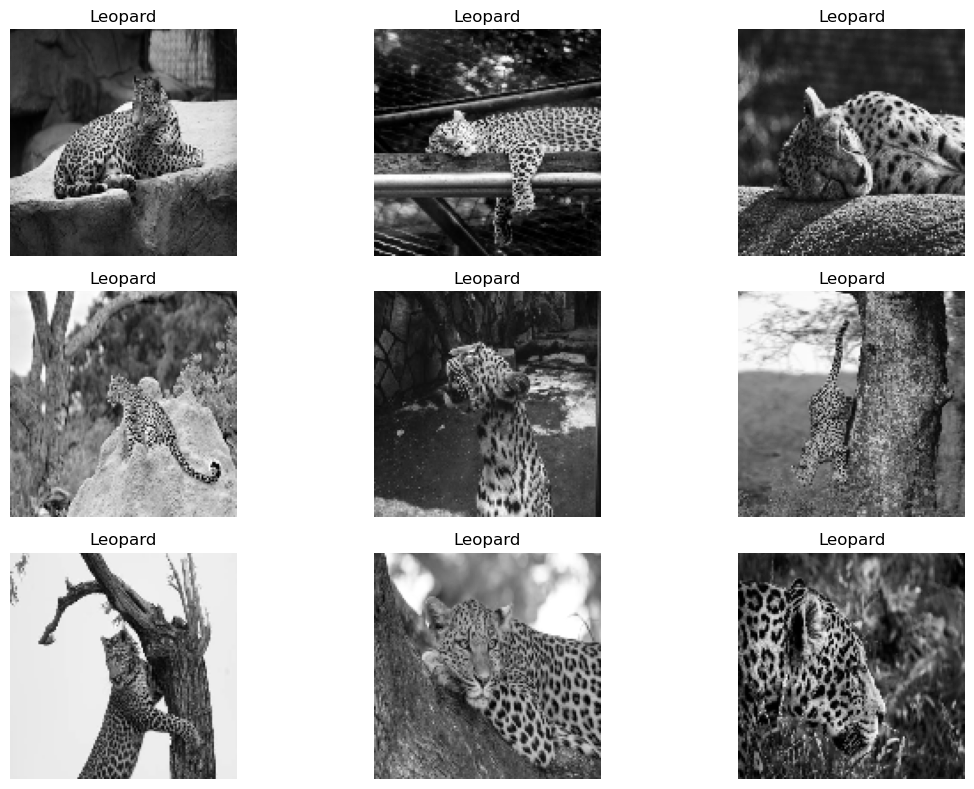

In [41]:
# Display a few sample grayscale images
plt.figure(figsize=(12, 8))
for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray')  # Display the image in grayscale
    plt.title(labels[i])  # Title with the category
    plt.axis('off')  # Hide the axes
plt.tight_layout()
plt.show()


# Preprocess Data

In [16]:
# Flatten and normalize the images
num_samples = images.shape[0]
flattened_images = images.reshape(num_samples, -1) / 255.0

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print(f"Labels encoded into {len(set(encoded_labels))} unique classes.")


Labels encoded into 5 unique classes.


# k-NN Classification with K-Fold Cross-Validation

In [18]:
# Define function for Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_values = range(1, 31)
accuracy_results = {k: [] for k in k_values}

for k in k_values:
    print(f"\nEvaluating for K = {k}")
    accuracy_list = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(flattened_images)):
        X_train, X_val = flattened_images[train_idx], flattened_images[val_idx]
        y_train, y_val = encoded_labels[train_idx], encoded_labels[val_idx]

        correct_predictions = 0
        for i in range(len(X_val)):
            test_image = X_val[i]
            true_label = y_val[i]

            distances = [euclidean_distance(test_image, train_image) for train_image in X_train]
            nearest_indices = np.argsort(distances)[:k]
            nearest_labels = [y_train[idx] for idx in nearest_indices]
            predicted_label = Counter(nearest_labels).most_common(1)[0][0]

            if predicted_label == true_label:
                correct_predictions += 1

        fold_accuracy = correct_predictions / len(X_val)
        accuracy_list.append(fold_accuracy)
        print(f"  Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")

    accuracy_results[k] = accuracy_list
    print(f"  Average Accuracy for K = {k}: {np.mean(accuracy_list):.4f}")



Evaluating for K = 1
  Fold 1 Accuracy: 0.1471
  Fold 2 Accuracy: 0.2353
  Fold 3 Accuracy: 0.1471
  Fold 4 Accuracy: 0.2059
  Fold 5 Accuracy: 0.2353
  Average Accuracy for K = 1: 0.1941

Evaluating for K = 2
  Fold 1 Accuracy: 0.1471
  Fold 2 Accuracy: 0.2353
  Fold 3 Accuracy: 0.1471
  Fold 4 Accuracy: 0.2059
  Fold 5 Accuracy: 0.2353
  Average Accuracy for K = 2: 0.1941

Evaluating for K = 3
  Fold 1 Accuracy: 0.1471
  Fold 2 Accuracy: 0.1765
  Fold 3 Accuracy: 0.1471
  Fold 4 Accuracy: 0.2647
  Fold 5 Accuracy: 0.2059
  Average Accuracy for K = 3: 0.1882

Evaluating for K = 4
  Fold 1 Accuracy: 0.0882
  Fold 2 Accuracy: 0.2941
  Fold 3 Accuracy: 0.1471
  Fold 4 Accuracy: 0.1765
  Fold 5 Accuracy: 0.1176
  Average Accuracy for K = 4: 0.1647

Evaluating for K = 5
  Fold 1 Accuracy: 0.2059
  Fold 2 Accuracy: 0.3235
  Fold 3 Accuracy: 0.1176
  Fold 4 Accuracy: 0.1176
  Fold 5 Accuracy: 0.1765
  Average Accuracy for K = 5: 0.1882

Evaluating for K = 6
  Fold 1 Accuracy: 0.2059
  Fold 

 # Calculate Centroids and Visualize Results

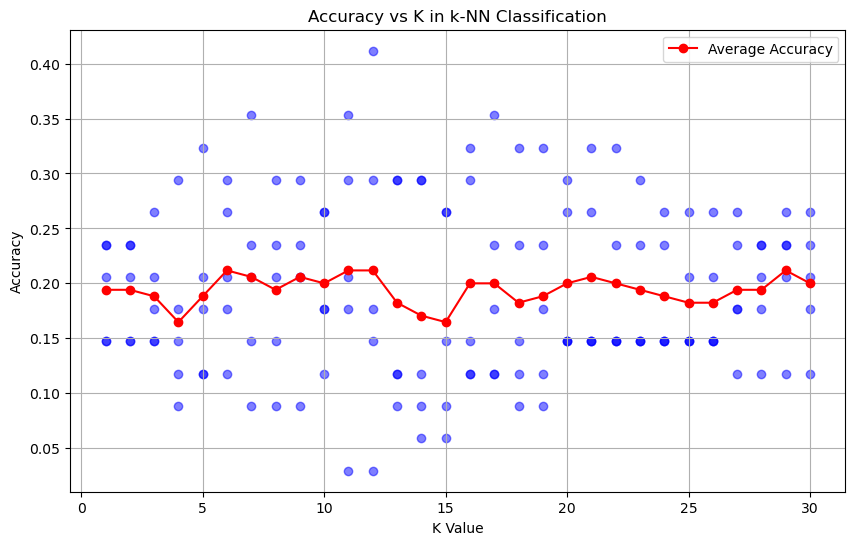

In [20]:
# Calculate average accuracy for each K
centroid_accuracies = {k: np.mean(accuracy_results[k]) for k in k_values}

# Plotting accuracy vs K
plt.figure(figsize=(10, 6))

# Plot fold accuracies and average accuracy
for k in k_values:
    for i, acc in enumerate(accuracy_results[k]):
        plt.scatter(k, acc, color='blue', alpha=0.5)

plt.plot(k_values, [centroid_accuracies[k] for k in k_values], marker='o', color='red', label='Average Accuracy')
plt.title('Accuracy vs K in k-NN Classification')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
